In [1]:
!uv pip install huggingface_hub transformers datasets evaluate albumentations

Using Python 3.12.12 environment at: /usr
Resolved 54 packages in 826ms                                        
Prepared 1 package in 25ms                                               
Installed 1 package in 3ms                                  
 + evaluate==0.4.6


In [ ]:
model_checkpoint = "wambugu71/crop_leaf_diseases_vit" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [3]:
from huggingface_hub import notebook_login

notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [7]:
from datasets import load_dataset 

# load a custom dataset from local/remote files using the ImageFolder feature

# option 1: local/remote files
dataset = load_dataset("Saon110/bd-crop-vegetable-plant-disease-dataset")

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub ...
# dataset = load_dataset("cifar10")

data/train-00000-of-00006.parquet:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/2.19G [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/675M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/340M [00:00<?, ?B/s]

data/valid-00000-of-00002.parquet:   0%|          | 0.00/2.38G [00:00<?, ?B/s]

data/valid-00001-of-00002.parquet:   0%|          | 0.00/1.55G [00:00<?, ?B/s]

data/test-00000-of-00004.parquet:   0%|          | 0.00/640M [00:00<?, ?B/s]

data/test-00001-of-00004.parquet:   0%|          | 0.00/562M [00:00<?, ?B/s]

data/test-00002-of-00004.parquet:   0%|          | 0.00/669M [00:00<?, ?B/s]

data/test-00003-of-00004.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/86467 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/24698 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12423 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/31 [00:00<?, ?it/s]

In [8]:
import evaluate

metric = evaluate.load("accuracy")

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 86467
    })
    valid: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 24698
    })
    test: Dataset({
        features: ['image', 'label', 'label_name'],
        num_rows: 12423
    })
})

To access an actual element, you need to select a split first, then give an index:

In [10]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x750>,
 'label': 0,
 'label_name': 'Banana_Black_Pitting_or_Banana_Rust'}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [11]:
dataset["train"].features

{'image': Image(mode=None, decode=True),
 'label': Value('int64'),
 'label_name': Value('string')}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

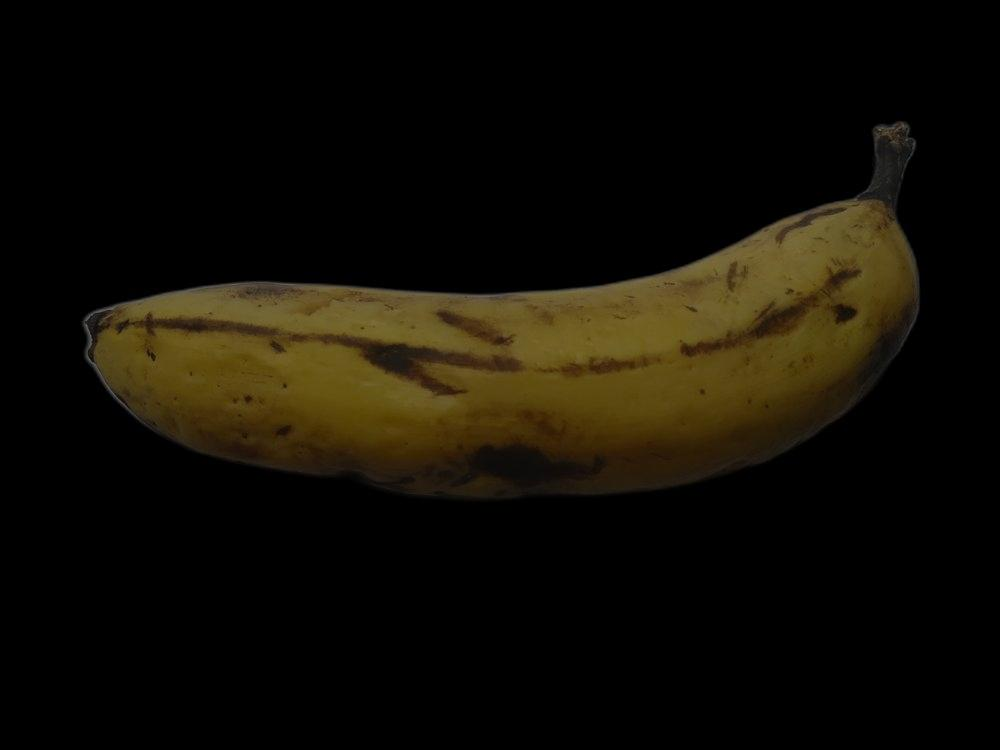

In [12]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

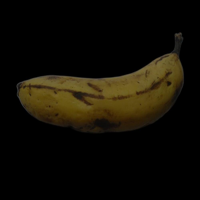

In [13]:
example['image'].resize((200, 200))

Let's check the corresponding label:

In [14]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [15]:
dataset["train"].features["label"]

Value('int64')

In [16]:
labels = dict(zip(dataset["train"]["label"], dataset["train"]["label_name"]))
labels

{0: 'Banana_Black_Pitting_or_Banana_Rust',
 1: 'Banana_Crown_Rot',
 2: 'Banana_Healthy',
 3: 'Banana_fungal_disease',
 4: 'Banana_leaf_Banana_Scab_Moth',
 5: 'Banana_leaf_Black_Sigatoka',
 6: 'Banana_leaf_Healthy',
 7: 'Banana_leaf__Black_Leaf_Streak',
 8: 'Banana_leaf__Panama_Disease.',
 9: 'Cauliflower_Bacterial_spot_rot',
 10: 'Cauliflower_Black_Rot',
 11: 'Cauliflower_Downy_Mildew',
 12: 'Cauliflower_Healthy',
 13: 'Corn_Blight',
 14: 'Corn_Common_Rust',
 15: 'Corn_Gray_Leaf_Spot',
 16: 'Corn_Healthy',
 17: 'Cotton_Aphids',
 18: 'Cotton_Army worm',
 19: 'Cotton_Bacterial blight',
 20: 'Cotton_Healthy',
 21: 'Guava_fruit_Anthracnose',
 22: 'Guava_fruit_Healthy',
 23: 'Guava_fruit_Scab',
 24: 'Guava_fruit_Styler_end_root',
 25: 'Guava_leaf_Anthracnose',
 26: 'Guava_leaf_Canker',
 27: 'Guava_leaf_Dot',
 28: 'Guava_leaf_Healthy',
 29: 'Guava_leaf_Rust',
 30: 'Jute_Cescospora Leaf Spot',
 31: 'Jute_Golden Mosaic',
 32: 'Jute_Healthy Leaf',
 33: 'Mango_Anthracnose',
 34: 'Mango_Bacterial

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [17]:
label_names = dict(zip(dataset["train"]["label"], dataset["train"]["label_name"]))
label2id = {label: i for i, label in label_names.items()}
id2label = label_names

id2label[2]

'Banana_Healthy'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `Albumentations` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [torchvision's transforms](https://pytorch.org/vision/stable/transforms.html), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [18]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


ViTImageProcessorFast {
  "data_format": "channels_first",
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [19]:
import cv2
import albumentations as A
import numpy as np

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = A.Compose([
    A.Resize(height=size[0], width=size[1]),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
])

val_transforms = A.Compose([
    A.Resize(height=size[0], width=size[1]),
    A.Normalize(),
])

def _to_rgb_array(image):
    """Convert PIL/array images to RGB numpy array with 3 channels."""
    if hasattr(image, "mode") and image.mode != "RGB":
        image = image.convert("RGB")
    arr = np.array(image)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    elif arr.shape[-1] == 4:
        arr = arr[..., :3]
    return arr

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image=_to_rgb_array(image))["image"] for image in examples["image"]
    ]

    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image=_to_rgb_array(image))["image"] for image in examples["image"]
    ]

    return examples

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [20]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [21]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's check the first example:

In [22]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3024x4032>,
 'label': 23,
 'label_name': 'Guava_fruit_Scab',
 'pixel_values': array([[[2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         ...,
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999]],
 
        [[2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         ...,
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999]],
 
        [[2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         ...,
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999],
         [2.2489083, 2.4285712, 2.6399999]],
 
        ...,
 


### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Like with the image processor, the `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels`, `label2id`, and `id2label` alongside the `model_checkpoint` he£re.

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons.

In [23]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you'd like to fine-tune an already fine-tuned checkpoint
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: wambugu71/crop_leaf_diseases_vit
Key               | Status   |                                                                                       
------------------+----------+---------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([13]) vs model:torch.Size([94])          
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([13, 192]) vs model:torch.Size([94, 192])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


The warning is telling us we are throwing away some weights (the weights and bias of the `pooler` layer) and randomly initializing some other (the weights and bias of the `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('img' in particular) in order to create 'pixel_values'.

In [24]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-bengal-crops",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    save_only_model= True,
    optim="adamw_torch",  # avoid fused optimizer to stay compatible with XLA/TPU
)


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [25]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [26]:
import numpy as np
import torch

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        image = example["pixel_values"]
        if image.ndim == 2:
            image = np.stack([image, image, image], axis=-1)
        elif image.shape[-1] == 4:
            image = image[..., :3]
        image = np.moveaxis(image, source=2, destination=0)
        images.append(torch.from_numpy(image))
        labels.append(example["label"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
if "validation" not in dataset and "valid" in dataset:
	dataset["validation"] = dataset["valid"]

if "validation" in dataset:
	dataset["validation"].set_transform(preprocess_val)

train_result = trainer.train()

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.save_model()

In [ ]:
metrics = trainer.evaluate(dataset['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'Saon110/bd-crop-vegetable-plant-disease-dataset',
    "tags": ['image-classification'],
}
import torch

# ... after training ...
model_save_name = f"{model_name}-finetuned-bengal-crops"
torch.save(model.state_dict(), model_save_name)

from google.colab import files
files.download(model_save_name)

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
print(metrics)

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card for you, as well as adding Tensorboard metrics - see the "Training metrics" tab!):

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a highway (that's not part of the EuroSAT dataset), and see how the model does.

In [ ]:
from PIL import Image
import requests

url = 'https://www.google.com/url?sa=t&source=web&rct=j&url=https%3A%2F%2Fwww.britannica.com%2Fscience%2Fplant-disease&ved=0CBYQjRxqFwoTCKi9tqz6wpIDFQAAAAAdAAAAABAI&opi=89978449'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the image processor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Looks like our model got it correct! 

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations")

In [ ]:
pipe(image)

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and image_processor:

In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [ ]:
pipe(image)